In [254]:
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pickle
import csv
import os
%matplotlib inline

path="C:\\Users\\Anjana Puri\\Documents\\Python\\TennisProject\\JosephSackmann Data\\tennis_atp-master\\tennis_atp-master"
os.chdir(path)



In [255]:
#load in all relevant data files
pickle_file = "player_serve_info.pkl"
with open(pickle_file, 'rb') as handle:
    player_serve_info = pickle.load(handle)
    
pickle_file = "player_match_number_info.pkl"
with open(pickle_file, 'rb') as handle:
    num_matches = pickle.load(handle)
    
pickle_file = "name_to_id.pkl"
with open(pickle_file, 'rb') as handle:
    name_to_id = pickle.load(handle)

pickle_file = "id_to_name.pkl"
with open(pickle_file, 'rb') as handle:
    id_to_name = pickle.load(handle)

    
with open('active_players.csv', 'r') as f:
    reader = csv.reader(f)
    player_list = list(reader)
active_player_list=[''.join(x) for x in list(filter(lambda a: a != [], player_list))]    

with open('top_30_players.csv', 'r') as f:
    reader = csv.reader(f)
    top_player_list = list(reader)
top_player_list=[''.join(x) for x in list(filter(lambda a: a != [], top_player_list))] 

mc_df= pd.read_pickle('MC_results.pkl')

In [256]:
df=pd.read_pickle('enhancement_metrics.pkl')
def serve_retrieve(p1,p2):
    return df.loc[p2,p1]["Serve percentages"]


match_number_df=df.copy().reset_index()
match_number_df=match_number_df[match_number_df['Number of Matches']>=10]


#look at a slice of all places with greater than 10 matches and create a matrix of all relevant serving statistics and win percentages
#these values will be used as features/classes later
match_number_df['Win Percentage']=match_number_df['Number of Wins']/match_number_df['Number of Matches']
match_number_df['P1 FSWP']=match_number_df['Serve percentages'].apply(lambda x: x[0]*x[1])
match_number_df['P1 SSWP']=match_number_df['Serve percentages'].apply(lambda x: x[2]*x[3])
match_number_df['P2 FSWP']=list(match_number_df[['Player 1 (P1)','Player 2 (P2)']].apply(lambda x: serve_retrieve(*x)[0]*serve_retrieve(*x)[1], axis=1))
match_number_df['P2 SSWP']=list(match_number_df[['Player 1 (P1)','Player 2 (P2)']].apply(lambda x: serve_retrieve(*x)[2]*serve_retrieve(*x)[3], axis=1))
data_matrix=match_number_df[['Win Percentage','P1 FSWP','P1 SSWP','P2 FSWP','P2 SSWP']]



In [257]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression


#perform linear regression using this feature/class data

X_train, X_test, y_train, y_test = train_test_split(data_matrix.iloc[:,1:], data_matrix.iloc[:,0])

linridge = LinearRegression().fit(X_train, y_train)


print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test, y_test)))


R-squared score (training): 0.763
R-squared score (test): 0.786


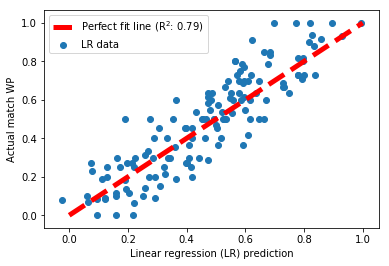

In [259]:
#plot results of test data prediction from LR model against actual player winning percentages

x_data_ml=linridge.predict(X_test)
y_data_ml=y_test

plt.figure()
plt.scatter(x_data_ml,y_data_ml,label='LR data')
rsquared=1-sum((np.array(y_data_ml)-np.array(x_data_ml))**2)/sum((np.array(y_data_ml)-np.mean(y_data_ml))**2)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),linewidth=5,color='red',linestyle='--',label='Perfect fit line (R$^2$: {:.2f})'.format(rsquared))
plt.xlabel('Linear regression (LR) prediction')
plt.ylabel('Actual match WP')
plt.legend()
plt.savefig('ML_vs_WLR_calibration.png')


In [260]:
safe_strat_df=df.copy().reset_index()
safe_strat_df=safe_strat_df[safe_strat_df['Number of Matches']>=5]
selection1=list(safe_strat_df['Player 1 (P1)'].apply(lambda x:  True if (x in active_player_list) and (x in top_player_list) else False))
safe_strat_df=safe_strat_df[selection1]
selection2=list(safe_strat_df['Player 2 (P2)'].apply(lambda x: True if (x in active_player_list) and (x in top_player_list) else False))
safe_strat_df=safe_strat_df[selection2]


safe_strat_df['P1 FSWP']=safe_strat_df['Serve percentages'].apply(lambda x: x[0]*x[1])
safe_strat_df['P1 SSWP']=safe_strat_df['Serve percentages'].apply(lambda x: x[2]*x[3])
safe_strat_df['P2 FSWP']=list(safe_strat_df[['Player 1 (P1)','Player 2 (P2)']].apply(lambda x: serve_retrieve(*x)[0]*serve_retrieve(*x)[1], axis=1))
safe_strat_df['P2 SSWP']=list(safe_strat_df[['Player 1 (P1)','Player 2 (P2)']].apply(lambda x: serve_retrieve(*x)[2]*serve_retrieve(*x)[3], axis=1))
data_matrix=safe_strat_df[['Player 1 (P1)','Player 2 (P2)','P1 FSWP','P1 SSWP','P2 FSWP','P2 SSWP']]
safe_predict=linridge.predict(data_matrix.iloc[:,2:])

In [261]:
#okay now let's construct a dataframe of all top30 active player matchup and construct our feature matrix just like above

risky_strat_df=df.copy().reset_index()
risky_strat_df=risky_strat_df[risky_strat_df['Number of Matches']>=5]
selection1=list(risky_strat_df['Player 1 (P1)'].apply(lambda x:  True if (x in active_player_list) and (x in top_player_list) else False))
risky_strat_df=risky_strat_df[selection1]
selection2=list(risky_strat_df['Player 2 (P2)'].apply(lambda x: True if (x in active_player_list) and (x in top_player_list) else False))
risky_strat_df=risky_strat_df[selection2]

risky_strat_df['P1 FSWP']=risky_strat_df['Serve percentages'].apply(lambda x: x[0]*x[1])
risky_strat_df['P1 SSWP']=risky_strat_df['Serve percentages'].apply(lambda x: x[0]*x[1])
risky_strat_df['P2 FSWP']=list(risky_strat_df[['Player 1 (P1)','Player 2 (P2)']].apply(lambda x: serve_retrieve(*x)[0]*serve_retrieve(*x)[1], axis=1))
risky_strat_df['P2 SSWP']=list(risky_strat_df[['Player 1 (P1)','Player 2 (P2)']].apply(lambda x: serve_retrieve(*x)[2]*serve_retrieve(*x)[3], axis=1))
data_matrix=risky_strat_df[['Player 1 (P1)','Player 2 (P2)','P1 FSWP','P1 SSWP','P2 FSWP','P2 SSWP']]
risky_predict=linridge.predict(data_matrix.iloc[:,2:])

In [262]:
#now store the difference between the risky strat win percentage predictions and the safe strat predicitons
players_names=data_matrix.iloc[:,0:2].values
ML_results=sorted([(id_to_name[players_names[i][0]],id_to_name[players_names[i][1]],risky_predict[i]-safe_predict[i]) for i in range(len(players_names))],key=lambda x:x[2],reverse=True)

In [172]:
#now consttruct a similar dataframr for the MC method (restrict to top 30 players with 5 matches in matchup history)


model_scale=0.8701
def calculate_diff(WP1,WP2): #WP1 = MC winning percentage with strategy (x), WP2= MC winning percentage with strategy (y)
                            #return: expected difference in real-life win percentages according to earlier fit function
    return model_scale*(WP1-WP2)

mc_df=pd.read_pickle('MC_results.pkl')
mc_df=mc_df[mc_df['Real life number of matches']>=5]
mc_df['Model differences']=list(map(calculate_diff,mc_df['Bold MC win percentage'],mc_df['Timid MC win percentage']))
active_matchup_list=mc_df.copy().reset_index()[['Player 1 Name','Player 2 Name','Real life number of matches','Model differences']]
active_matchup_list=active_matchup_list[active_matchup_list['Player 1 Name'].apply(lambda x: name_to_id[x] in top_player_list) & active_matchup_list['Player 2 Name'].apply(lambda x: name_to_id[x] in top_player_list)]
active_matchup_list=active_matchup_list[active_matchup_list['Real life number of matches']>=5].sort_values(by='Model differences')
selection1=list(active_matchup_list['Player 1 Name'].apply(lambda x:  True if name_to_id[x] in active_player_list else False))
active_matchup_list=active_matchup_list[selection1]
selection2=list(active_matchup_list['Player 2 Name'].apply(lambda x: True if name_to_id[x] in active_player_list else False))
active_matchup_list=active_matchup_list[selection2][['Player 1 Name','Player 2 Name','Model differences']]

In [263]:
#now we want to compare the MC and ML results
#create some dictionaries to map each model to the relevant predicitons
#I could have kept both things in the data frame here but decided not in case the dict is convenient later


MC_result=active_matchup_list.values
MC_dict={}
ML_dict={}
for item in MC_result:
    MC_dict[(item[0],item[1])]=item[2]
for item in ML_results:
    ML_dict[(item[0],item[1])]=item[2]


In [264]:
# now populate vectors with the predicitons for each matchup, with the value at the same index in each vector referring to a particular mathcup


x_predict=[]
y_predict=[]
for pairs in MC_dict.keys():
    try:
        x_predict.append(MC_dict[pairs])
        y_predict.append(ML_dict[pairs])
    except KeyError:
        pass

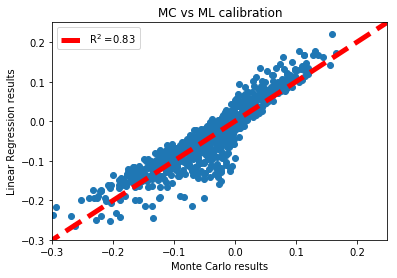

In [266]:
#finally let's plot hese vector against one another and check for a one-to-one correlation

plt.figure()
plt.scatter(x_predict,y_predict)
mean_values=np.mean(y_predict)
rsquared=1-sum((np.array(y_predict)-np.array(x_predict))**2)/sum((np.array(y_predict)-mean_values)**2)
plt.plot(np.linspace(-1,1,100),np.linspace(-1,1,100),linewidth=5,color='red',linestyle="--",label='R$^2$ ={:.2f}'.format(rsquared))
plt.xlim(-.3,.25)
plt.ylim(-.3,.25)
plt.xlabel('Monte Carlo results')
plt.ylabel('Linear Regression results')
plt.title('MC vs ML calibration')
plt.legend()
plt.savefig('ML_vs_MC_calibration.png')